In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# set up constants

BASE_GENRES = [
    "genre_blues",
    "genre_classical",
    "genre_country",
    "genre_disco",
    "genre_hiphop",
    "genre_jazz",
    "genre_metal",
    "genre_pop",
    "genre_reggae",
    "genre_rock"
]

STRATIFY = ['stratify']

KEY = ['metadata_path']

In [3]:
# load base dataframe

import pandas as pd

filepath = "/content/drive/MyDrive/w207/mids_w207_music_genre/member_workspaces/lawrence/mtg_jamendo_genre_features_base.feather"
df_base = pd.read_feather(filepath)

In [4]:
# split base data into train and test sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np


# get features
FEATURES = list(set(df_base.columns) - set(BASE_GENRES) - set(STRATIFY) - set(KEY))
X = df_base[FEATURES]

# get targets
enc = LabelEncoder()
y = enc.fit_transform(df_base[STRATIFY].values.reshape(-1))

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
  
# X_train, X_valid, y_train, y_valid = \
#     train_test_split(X_train, y_train, test_size=0.25, random_state=10, stratify=y_train)

print(F"X_train: {X_train.shape}")
# print(F"X_valid: {X_valid.shape}")
print(F"X_test:  {X_test.shape}")

# scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train, y_train)
# X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


X_train: (17080, 2739)
X_test:  (4271, 2739)


## Experiment \#1: GMM with 1 component

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

# for each class, fit a GM to get the pdf
gms = []

for y_value in np.unique(y_train):
  mask = (y_train == y_value)
  gm = GaussianMixture(n_components=1, random_state=10)
  gm.fit(X_train[mask, :])
  gms.append(gm)

# generate log likelihood for train and test sets using each GM
y_train_log_likelihoods = []
y_test_log_likelihoods = []

for gm in gms:
  y_train_log_likelihoods.append(gm.score_samples(X_train))
  y_test_log_likelihoods.append(gm.score_samples(X_test))

y_train_pred = np.argmax(np.array(y_train_log_likelihoods), axis=0).squeeze()
y_test_pred = np.argmax(np.array(y_test_log_likelihoods), axis=0).squeeze()

train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(F"Train accuracy: {train_accuracy}")
print(F"Test accuracy:  {test_accuracy}")

Train accuracy: 0.9927400468384074
Test accuracy:  0.5357059236712713


## Experiment \#2: GMM with 1-10 components

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

n_components_list = np.arange(1,11,1)
train_accuracies = []
test_accuracies = []

for n_components in n_components_list:

  # for each class, fit a GM to get the pdf
  gms = []

  for y_value in np.unique(y_train):
    mask = (y_train == y_value)
    gm = GaussianMixture(n_components=n_components, random_state=10)
    gm.fit(X_train[mask, :])
    gms.append(gm)

  # generate log likelihood for train and test sets using each GM
  y_train_log_likelihoods = []
  y_test_log_likelihoods = []

  for gm in gms:
    y_train_log_likelihoods.append(gm.score_samples(X_train))
    y_test_log_likelihoods.append(gm.score_samples(X_test))

  # determine predicted label based on maximum log likelihood
  y_train_pred = np.argmax(np.array(y_train_log_likelihoods), axis=0).squeeze()
  y_test_pred = np.argmax(np.array(y_test_log_likelihoods), axis=0).squeeze()

  train_accuracy = accuracy_score(y_train, y_train_pred)
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  test_accuracies.append(test_accuracy)

  print(F"Training GMM with n_components={n_components}...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  print(F"-"*100)

Training GMM with n_components=1...
Train accuracy: 0.9927400468384074
Test accuracy:  0.5357059236712713
----------------------------------------------------------------------------------------------------
Training GMM with n_components=2...
Train accuracy: 0.9998829039812647
Test accuracy:  0.4530554905174432
----------------------------------------------------------------------------------------------------
Training GMM with n_components=3...
Train accuracy: 0.999824355971897
Test accuracy:  0.3549520018730976
----------------------------------------------------------------------------------------------------
Training GMM with n_components=4...
Train accuracy: 0.9999414519906323
Test accuracy:  0.32849449777569656
----------------------------------------------------------------------------------------------------


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("GMM with different n_components")
ax.set_xlabel("n_components")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#2: GMM with 1 component and feature selection via select k best

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score

tolerance = 10
top_ns = np.arange(10,2010,10)
train_accuracies = []
test_accuracies = []

for top_n in top_ns:
  # feature selection via select k best
  mask_selected_features = np.full((X_train.shape[1], ), False)

  for y_value in np.unique(y_train):
    skb = SelectKBest(k=top_n)
    mask = y_train == y_value
    skb.fit(X_train[mask, :], y_train[mask])
    mask_selected_features |= skb.get_support()

  # for each class, fit a GM to get the pdf
  gms = []

  for y_value in np.unique(y_train):
    mask = (y_train == y_value)
    gm = GaussianMixture(n_components=3, random_state=10)
    gm.fit(X_train[mask, :][:, mask_selected_features])
    gms.append(gm)

  # generate log likelihood for train and test sets using each GM
  y_train_log_likelihoods = []
  y_test_log_likelihoods = []

  for gm in gms:
    y_train_log_likelihoods.append(gm.score_samples(X_train[:, mask_selected_features]))
    y_test_log_likelihoods.append(gm.score_samples(X_test[:, mask_selected_features]))

  # determine predicted label based on maximum log likelihood
  y_train_pred = np.argmax(np.array(y_train_log_likelihoods), axis=0).squeeze()
  y_test_pred = np.argmax(np.array(y_test_log_likelihoods), axis=0).squeeze()

  train_accuracy = accuracy_score(y_train, y_train_pred)
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  test_accuracies.append(test_accuracy)

  print(F"Training GMM with feature selection via select k best (k={top_n})...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy == 1:
    break
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=10)...
Train accuracy: 0.3671545667447307
Test accuracy:  0.35612268789510654
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=20)...
Train accuracy: 0.34314988290398124
Test accuracy:  0.3366892999297588
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=30)...
Train accuracy: 0.3659250585480094
Test accuracy:  0.34441582767501755
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=40)...
Train accuracy: 0.36826697892271665
Test accuracy:  0.34441582767501755
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=50)...
Train accuracy: 0.3721311475409836
Test accuracy:  0.341840318426598
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=60)...
Train accuracy: 0.4772833723653396
Test accuracy:  0.44369000234137207
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=70)...
Train accuracy: 0.48553864168618266
Test accuracy:  0.4385389838445329
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=80)...
Train accuracy: 0.4618852459016393
Test accuracy:  0.3963942870522126
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=90)...
Train accuracy: 0.5881147540983607
Test accuracy:  0.5038632638726294
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=100)...
Train accuracy: 0.5374121779859484
Test accuracy:  0.4460313743853898
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=110)...
Train accuracy: 0.577576112412178
Test accuracy:  0.4612502926715055
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=120)...
Train accuracy: 0.5152224824355972
Test accuracy:  0.3924139545773824
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=130)...
Train accuracy: 0.6521077283372365
Test accuracy:  0.5193163193631468
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=140)...
Train accuracy: 0.6138173302107728
Test accuracy:  0.4898150316085226
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=150)...
Train accuracy: 0.6035714285714285
Test accuracy:  0.46897682041676425
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=160)...
Train accuracy: 0.6353629976580796
Test accuracy:  0.4701475064387731
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=170)...
Train accuracy: 0.6445550351288056
Test accuracy:  0.48723952236010304
Overfitting detected!
----------------------------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWarning: invalid value encountered in true_divide
  msb = ssbn / float(dfbn)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:108: RuntimeWar

Training GMM with feature selection via select k best (k=180)...
Train accuracy: 0.7098946135831382
Test accuracy:  0.5380472957152892
Overfitting detected!


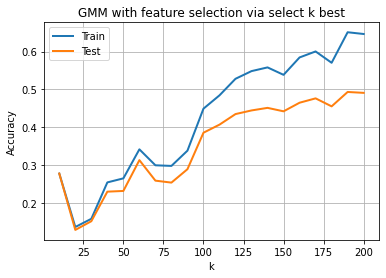

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(top_ns[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(top_ns[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("GMM with feature selection via select k best")
ax.set_xlabel("k")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#3: GMM with feature selection via random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, 
                             max_depth=500, 
                             random_state=10)
clf.fit(X_train, y_train)
df_feature_importance = pd.DataFrame({"feature_name": FEATURES, 
                                      "feature_importance": clf.feature_importances_})
df_feature_importance.sort_values(by="feature_importance", ascending=False, inplace=True)

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

top_ns = np.arange(10, 2010, 10)
train_accuracies = []
test_accuracies = []

for top_n in top_ns:
  top_features = df_feature_importance.head(top_n)['feature_name'].unique()
  feature_indices = [FEATURES.index(f) for f in top_features]

  # for each class, fit a GM to get the pdf
  gms = []

  for y_value in np.unique(y_train):
    mask = (y_train == y_value)
    gm = GaussianMixture(n_components=1, random_state=10)
    gm.fit(X_train[mask, :][:, feature_indices])
    gms.append(gm)

  # generate log likelihood for train and test sets using each GM
  y_train_log_likelihoods = []
  y_test_log_likelihoods = []

  for gm in gms:
    y_train_log_likelihoods.append(gm.score_samples(X_train[:, feature_indices]))
    y_test_log_likelihoods.append(gm.score_samples(X_test[:, feature_indices]))

  # determine predicted label based on maximum log likelihood
  y_train_pred = np.argmax(np.array(y_train_log_likelihoods), axis=0).squeeze()
  y_test_pred = np.argmax(np.array(y_test_log_likelihoods), axis=0).squeeze()

  train_accuracy = accuracy_score(y_train, y_train_pred)
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  test_accuracies.append(test_accuracy)

  print(F"Training GMM with feature selection via random forest (k={top_n})...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy == 1:
    break
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Training GMM with feature selection via random forest (k=10)...
Train accuracy: 0.3018149882903981
Test accuracy:  0.2966518379770546
----------------------------------------------------------------------------------------------------
Training GMM with feature selection via random forest (k=20)...
Train accuracy: 0.3225995316159251
Test accuracy:  0.3151486771247951
----------------------------------------------------------------------------------------------------
Training GMM with feature selection via random forest (k=30)...
Train accuracy: 0.3347189695550351
Test accuracy:  0.32521657691407163
----------------------------------------------------------------------------------------------------
Training GMM with feature selection via random forest (k=40)...
Train accuracy: 0.3500585480093677
Test accuracy:  0.3362210255209553
----------------------------------------------------------------------------------------------------
Training GMM with feature selection via random forest (k=50

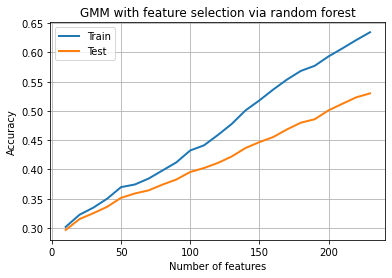

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(top_ns[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(top_ns[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("GMM with feature selection via random forest")
ax.set_xlabel("Number of features")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#4: GMM with PCA

In [ ]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

n_components_list = np.arange(10, 510, 10)
train_accuracies = []
test_accuracies = []

for n_components in n_components_list:
  # get pca
  pca = PCA(n_components)
  X_train_pca = pca.fit_transform(X_train)
  X_test_pca = pca.transform(X_test)

  # for each class, fit a GM to get the pdf
  gms = []

  for y_value in np.unique(y_train):
    mask = (y_train == y_value)
    gm = GaussianMixture(n_components=1, random_state=10)
    gm.fit(X_train_pca[mask, :])
    gms.append(gm)

  # generate log likelihood for train and test sets using each GM
  y_train_log_likelihoods = []
  y_test_log_likelihoods = []

  for gm in gms:
    y_train_log_likelihoods.append(gm.score_samples(X_train_pca))
    y_test_log_likelihoods.append(gm.score_samples(X_test_pca))

  # determine predicted label based on maximum log likelihood
  y_train_pred = np.argmax(np.array(y_train_log_likelihoods), axis=0).squeeze()
  y_test_pred = np.argmax(np.array(y_test_log_likelihoods), axis=0).squeeze()

  train_accuracy = accuracy_score(y_train, y_train_pred)
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  test_accuracies.append(test_accuracy)

  print(F"Training GMM with dimensionality reduction via PCA (n_components={n_components})...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy == 1:
    break
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Training GMM with dimensionality reduction via PCA (n_components=10)...
Train accuracy: 0.24379391100702577
Test accuracy:  0.24233200655584172
----------------------------------------------------------------------------------------------------
Training GMM with dimensionality reduction via PCA (n_components=20)...
Train accuracy: 0.2601288056206089
Test accuracy:  0.26036057129477874
----------------------------------------------------------------------------------------------------
Training GMM with dimensionality reduction via PCA (n_components=30)...
Train accuracy: 0.27646370023419203
Test accuracy:  0.26715055022243034
----------------------------------------------------------------------------------------------------
Training GMM with dimensionality reduction via PCA (n_components=40)...
Train accuracy: 0.30339578454332555
Test accuracy:  0.2858815265745727
----------------------------------------------------------------------------------------------------
Training GMM with dime

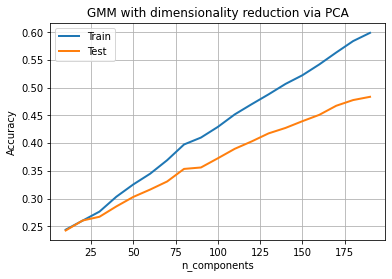

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("GMM with dimensionality reduction via PCA")
ax.set_xlabel("n_components")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#5: GMM with MFCC

In [16]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

# get mfcc means
mfcc_means = [f for f in FEATURES if f.startswith("mfcc_mean")]
feature_indices = [FEATURES.index(f) for f in mfcc_means]

tolerance = 10
n_components_list = np.arange(1,11,1)
train_accuracies = []
test_accuracies = []

for n_components in n_components_list:
  # for each class, fit a GM to get the pdf
  gms = []

  for y_value in np.unique(y_train):
    mask = (y_train == y_value)
    gm = GaussianMixture(n_components=n_components, random_state=10)
    gm.fit(X_train[mask, :][:, feature_indices])
    gms.append(gm)

  # generate log likelihood for train and test sets using each GM
  y_train_log_likelihoods = []
  y_test_log_likelihoods = []

  for gm in gms:
    y_train_log_likelihoods.append(gm.score_samples(X_train[:, feature_indices]))
    y_test_log_likelihoods.append(gm.score_samples(X_test[:, feature_indices]))

  y_train_pred = np.argmax(np.array(y_train_log_likelihoods), axis=0).squeeze()
  y_test_pred = np.argmax(np.array(y_test_log_likelihoods), axis=0).squeeze()

  train_accuracy = accuracy_score(y_train, y_train_pred)
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  test_accuracies.append(test_accuracy)

  print(F"Training GMM with MFCC means (n_components={n_components})...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy == 1:
    break
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Training GMM with MFCC means (n_components=1)...
Train accuracy: 0.3886416861826698
Test accuracy:  0.3790681339264809
----------------------------------------------------------------------------------------------------
Training GMM with MFCC means (n_components=2)...
Train accuracy: 0.43507025761124124
Test accuracy:  0.41512526340435496
----------------------------------------------------------------------------------------------------
Training GMM with MFCC means (n_components=3)...
Train accuracy: 0.4661007025761124
Test accuracy:  0.427768672442051
----------------------------------------------------------------------------------------------------
Training GMM with MFCC means (n_components=4)...
Train accuracy: 0.49350117096018736
Test accuracy:  0.441582767501756
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training GMM with MFCC means (n_components=5)...
Train accuracy: 0.5035714285714286
Test accuracy

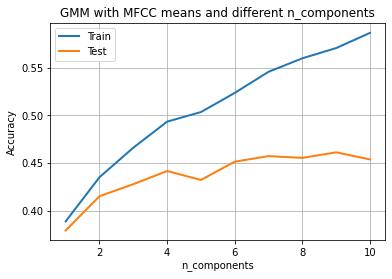

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("GMM with MFCC means and different n_components")
ax.set_xlabel("n_components")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#6: GMM with MFCC covariance matrix

In [21]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

# get mfcc covariance matrix
mfcc_covs = [f for f in FEATURES if f.startswith("mfcc_cov")]
feature_indices = [FEATURES.index(f) for f in mfcc_covs]

tolerance = 10
n_components_list = np.arange(1,11,1)
train_accuracies = []
test_accuracies = []

for n_components in n_components_list:
  # for each class, fit a GM to get the pdf
  gms = []

  for y_value in np.unique(y_train):
    mask = (y_train == y_value)
    gm = GaussianMixture(n_components=n_components, random_state=10)
    gm.fit(X_train[mask, :][:, feature_indices])
    gms.append(gm)

  # generate log likelihood for train and test sets using each GM
  y_train_log_likelihoods = []
  y_test_log_likelihoods = []

  for gm in gms:
    y_train_log_likelihoods.append(gm.score_samples(X_train[:, feature_indices]))
    y_test_log_likelihoods.append(gm.score_samples(X_test[:, feature_indices]))

  y_train_pred = np.argmax(np.array(y_train_log_likelihoods), axis=0).squeeze()
  y_test_pred = np.argmax(np.array(y_test_log_likelihoods), axis=0).squeeze()

  train_accuracy = accuracy_score(y_train, y_train_pred)
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  test_accuracies.append(test_accuracy)

  print(F"Training GMM with MFCC covariance matrix (n_components={n_components})...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy == 1:
    break
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Training GMM with MFCC covariance matrix (n_components=1)...
Train accuracy: 0.45556206088992973
Test accuracy:  0.38421915242332005
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training GMM with MFCC covariance matrix (n_components=2)...
Train accuracy: 0.6221896955503513
Test accuracy:  0.4736595645047998
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training GMM with MFCC covariance matrix (n_components=3)...
Train accuracy: 0.7007611241217798
Test accuracy:  0.5001170686022008
Overfitting detected!
----------------------------------------------------------------------------------------------------
Training GMM with MFCC covariance matrix (n_components=4)...
Train accuracy: 0.7398126463700234
Test accuracy:  0.4952001873097635
Overfitting detected!
-----------------------------------------------------------------------------------

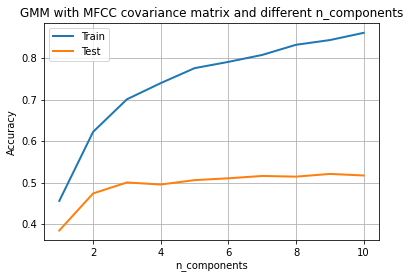

In [22]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("GMM with MFCC covariance matrix and different n_components")
ax.set_xlabel("n_components")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()

## Experiment \#7: GMM with MFCC inverse covariance matrix

In [23]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score

# get mfcc inverse covariance matrix
mfcc_icovs = [f for f in FEATURES if f.startswith("mfcc_icov")]
feature_indices = [FEATURES.index(f) for f in mfcc_icovs]

tolerance = 10
n_components_list = np.arange(1,11,1)
train_accuracies = []
test_accuracies = []

for n_components in n_components_list:
  # for each class, fit a GM to get the pdf
  gms = []

  for y_value in np.unique(y_train):
    mask = (y_train == y_value)
    gm = GaussianMixture(n_components=n_components, random_state=10)
    gm.fit(X_train[mask, :][:, feature_indices])
    gms.append(gm)

  # generate log likelihood for train and test sets using each GM
  y_train_log_likelihoods = []
  y_test_log_likelihoods = []

  for gm in gms:
    y_train_log_likelihoods.append(gm.score_samples(X_train[:, feature_indices]))
    y_test_log_likelihoods.append(gm.score_samples(X_test[:, feature_indices]))

  y_train_pred = np.argmax(np.array(y_train_log_likelihoods), axis=0).squeeze()
  y_test_pred = np.argmax(np.array(y_test_log_likelihoods), axis=0).squeeze()

  train_accuracy = accuracy_score(y_train, y_train_pred)
  train_accuracies.append(train_accuracy)
  test_accuracy = accuracy_score(y_test, y_test_pred)
  test_accuracies.append(test_accuracy)

  print(F"Training GMM with MFCC inverse covariance matrix (n_components={n_components})...")
  print(F"Train accuracy: {train_accuracy}")
  print(F"Test accuracy:  {test_accuracy}")
  if train_accuracy == 1:
    break
  if train_accuracy > (test_accuracy+0.05):
    print(F"Overfitting detected!")
    if tolerance == 0:
      break
    tolerance -= 1
  else:
    tolerance = 10
  print(F"-"*100)

Training GMM with MFCC inverse covariance matrix (n_components=1)...
Train accuracy: 0.0971311475409836
Test accuracy:  0.09997658627955983
----------------------------------------------------------------------------------------------------
Training GMM with MFCC inverse covariance matrix (n_components=2)...
Train accuracy: 0.14379391100702577
Test accuracy:  0.14610161554671036
----------------------------------------------------------------------------------------------------
Training GMM with MFCC inverse covariance matrix (n_components=3)...
Train accuracy: 0.13864168618266978
Test accuracy:  0.1400140482322641
----------------------------------------------------------------------------------------------------
Training GMM with MFCC inverse covariance matrix (n_components=4)...
Train accuracy: 0.1537470725995316
Test accuracy:  0.1470381643643175
----------------------------------------------------------------------------------------------------
Training GMM with MFCC inverse covar

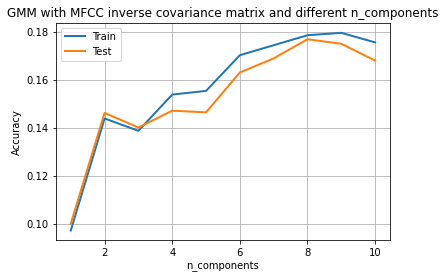

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(n_components_list[:len(train_accuracies)], train_accuracies, linewidth=2.0, label='Train')
ax.plot(n_components_list[:len(test_accuracies)], test_accuracies, linewidth=2.0, label='Test')
ax.set_title("GMM with MFCC inverse covariance matrix and different n_components")
ax.set_xlabel("n_components")
ax.set_ylabel("Accuracy")
ax.legend()
ax.grid()
fig.show()